<a href="https://colab.research.google.com/github/codiak/ds_notebooks/blob/main/NASA_Dataset_Near_Earth_Object_Hazard_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying Dangerous Near-Earth Objects

Using a NASA dataset of nearest Earth objects available through Kaggle, I will be building models using various techniques to identify hazardous objects.

First, the necessary library imports:

In [70]:
# library imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()


### Data Import and Initial Inspection

This NASA dataset of objects orbiting Earth was found through Kaggle and is available at the link below or in this project's Github repository.

In [72]:
# Kaggle dataset:
# https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects?resource=download
# NASA - Nearest Earth Objects

df = pd.read_csv("neo.csv")

df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


This dataset has 90,836 observations and 8 features (not including 'id' or the 'hazardous' label), and it looks like each one has each feature provided. The label of interest, 'hazardous', is what I will try to classify based on the other features.

### Data Cleaning

There are no null values according to dataframe.info(), but let's verify that there are no "null-like" values as well.

In [4]:
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

for c in df.columns:
    string_null = np.array([x in null_like for x in df[c]])
    print(c, df[c].isnull().sum(), string_null.sum()) 

id 0 0
name 0 0
est_diameter_min 0 0
est_diameter_max 0 0
relative_velocity 0 0
miss_distance 0 0
orbiting_body 0 0
sentry_object 0 0
absolute_magnitude 0 0
hazardous 0 0


Looks like this is a nicely prepared dataset without missing values. Now to explore each feature to see if anything is unusual about any of the counts. 

Note dropping the "name" and "id" columns since they will not provide any useful information for our model.

In [73]:
cleaned = df.drop(columns=["name", "id"])

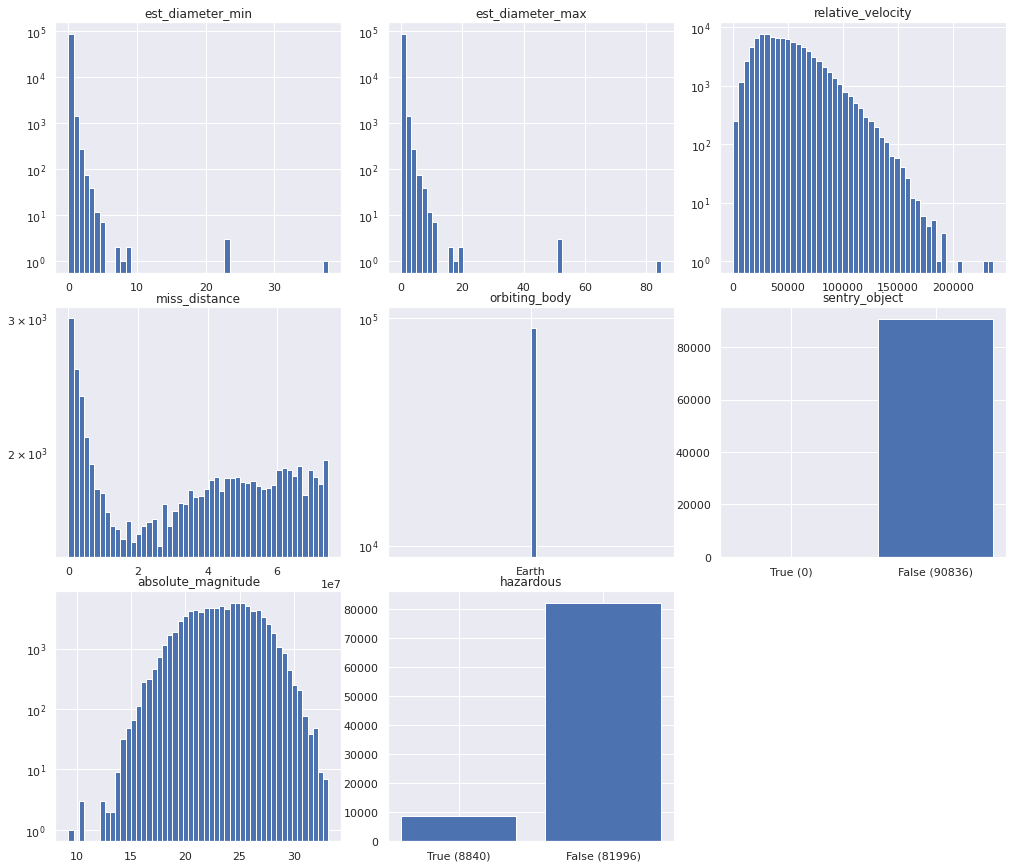

In [3]:
fig, a = plt.subplots(3,3) 
fig.set_figheight(12)
fig.set_figwidth(14)
fig.tight_layout()

for i, c in enumerate(cleaned.columns):
  data = cleaned[c]
  ax = a.flat[i]
  if data.dtype == 'bool':
    trues = np.count_nonzero(data)
    falses = np.size(data) - trues
    ax.bar(["True ({})".format(trues), "False ({})".format(falses)], [trues, falses])
  else:
    ax.hist(data, bins=50, log=True)
  ax.set_title(c)

for i in range(8,9):
  a.flat[i].set_visible(False)

#### Distribution Analysis

Looking at these histograms of the data, we can see:


*   "sentry_object" adds no information since all are False, and can be dropped
*   The only value for "orbiting_body" is "Earth", so it can be dropped as well
*   A logarthmic spread was needed to display this most of these features, particularly the "diameter" values, so larger values in those cases are rarer.
*   Even though we checked for null values, it looks like there might be a large number of zeros, and it might be worth verifying the minimum values for a few features.
*   There are substantially more False/negative examples (81k) than True/positive examples (8k).



In [74]:
# First lets drop the "sentry_object" feature
cleaned = cleaned.drop(columns=["sentry_object", "orbiting_body"])

# Then lets output minimum values and zero counts for each feature with a lot of potential zeros
for c in ["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance"]:
  col = cleaned[c]
  zeros = np.size(col) - np.count_nonzero(col)
  print("For column {}: {} zeros, {} minimum value".format( c, zeros, col.min()))

For column est_diameter_min: 0 zeros, 0.0006089126 minimum value
For column est_diameter_max: 0 zeros, 0.00136157 minimum value
For column relative_velocity: 0 zeros, 203.34643253 minimum value
For column miss_distance: 0 zeros, 6745.532515957 minimum value


Confirmed the data is not full of zeros, and unnecessary columns have been dropped.

In [75]:
cleaned.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


### Exploratory Data Analysis

I'll begin exploring the data using a heatmap of the correlation matrix.

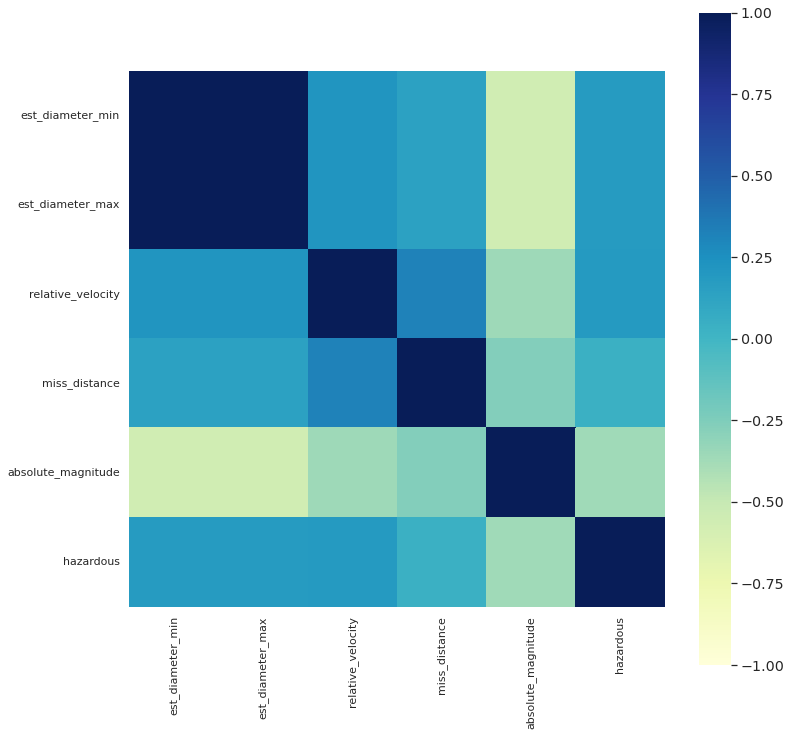

In [76]:
corr = cleaned.corr()
plt.subplots(figsize=(12,12))
sns.set(font_scale=1.3)
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)

**Correlation Matrix Analysis**

Based on the correlation matrix, it looks like "miss_distance" has the weakest correlation with "hazardous", and the rest of the features are roughly equivalent.

Looking at the actual values below, we can see that "absolute_magnitude" has the strongest correlation (-0.36) with "hazardous" and we can assume it will be our strongest predictor. The second strongest is "relative_velocity", followed by "est_diameter_min"/"est_diameter_max".

For further analysis, I've also added a pair plot below.

In [13]:
print(corr)

                    est_diameter_min  est_diameter_max  relative_velocity  \
est_diameter_min            1.000000          1.000000           0.221553   
est_diameter_max            1.000000          1.000000           0.221553   
relative_velocity           0.221553          0.221553           1.000000   
miss_distance               0.142241          0.142241           0.327169   
absolute_magnitude         -0.560188         -0.560188          -0.353863   
hazardous                   0.183363          0.183363           0.191185   

                    miss_distance  absolute_magnitude  hazardous  
est_diameter_min         0.142241           -0.560188   0.183363  
est_diameter_max         0.142241           -0.560188   0.183363  
relative_velocity        0.327169           -0.353863   0.191185  
miss_distance            1.000000           -0.264168   0.042302  
absolute_magnitude      -0.264168            1.000000  -0.365267  
hazardous                0.042302           -0.365267   1.

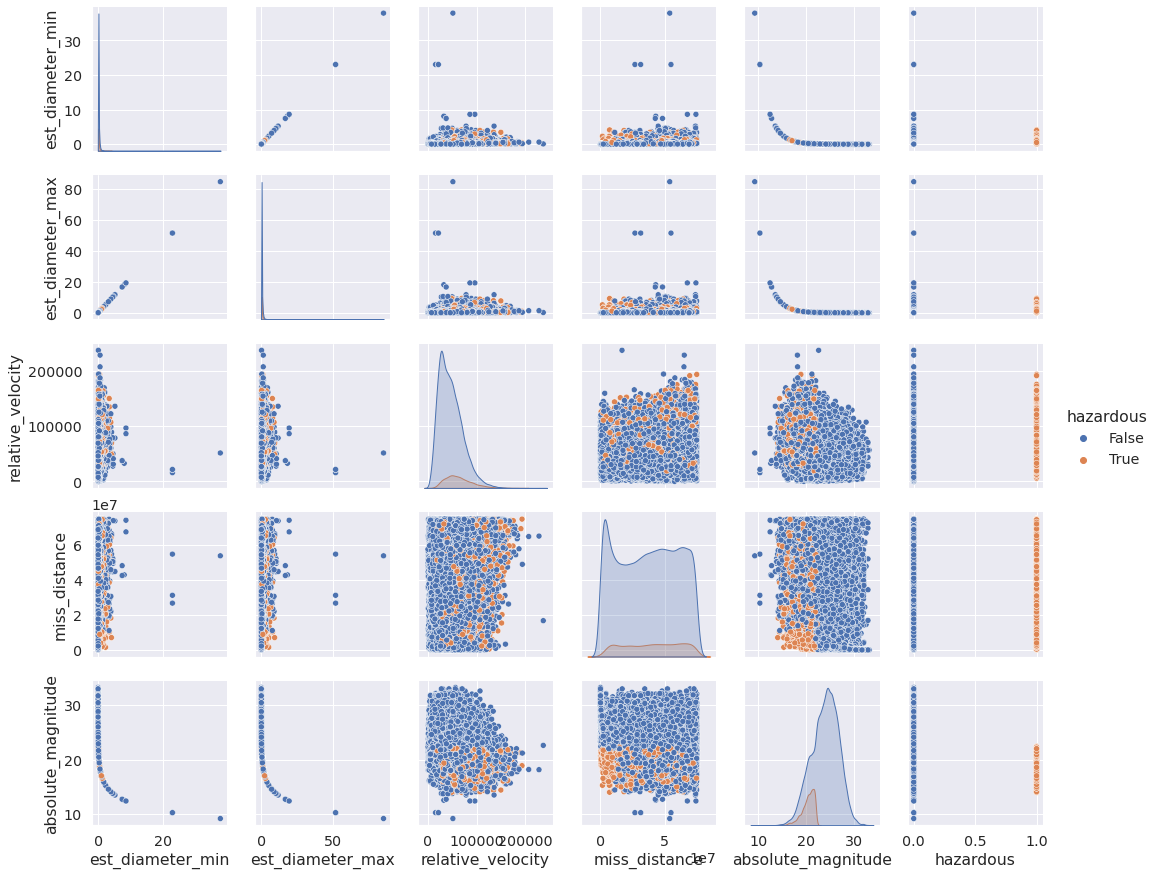

In [14]:
# Specifying y vars to avoid unsupported boolean comparison
sns.pairplot(cleaned, x_vars=cleaned.columns, 
             y_vars=["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"], 
             diag_kind="kde",
             hue="hazardous")

**Pair Plot Analysis**

Based on the pair plots, as well as the correlation matrix, we may need to consider removing "miss_distance" or using it to engineer another feature since it may add unneeded complexity to the model.

## Model Building

### Logistic Regression

The first model to build and test will be a Logistic Regression. Features are exponentially distributed, mostly quanitative, and otherwise not very sparse, so it should work well with this dataset. It can be used as a baseline for testing out other types of models as well.

In [17]:
# Prepare the data for training
shuffle(cleaned)
x = cleaned.drop(columns="hazardous")
y = cleaned["hazardous"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print("Training dataset sizes: {} in x_train, {} in y_train".format(len(x_train),len(y_train)))
print("Test dataset sizes: {} in x_test, {} in y_test".format(len(x_test), len(y_test)))

Training dataset sizes: 72668 in x_train, 72668 in y_train
Test dataset sizes: 18168 in x_test, 18168 in y_test


With the data prepared, setting aside 20% for test values, next is training:

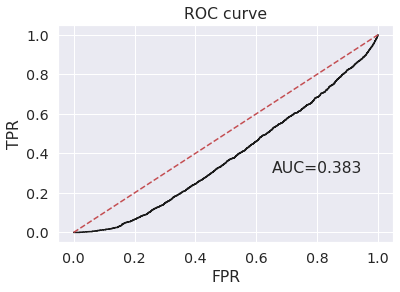

In [78]:
# Train initial, default model
LogReg = LogisticRegression().fit(x_train, y_train)

# Predict using model
y_pred = LogReg.predict(x_test)

# Evalluate model
yp_proba = LogReg.predict_proba(x_test)
fpr, tpr, th = roc_curve(y_test, yp_proba[:,1])
auc = roc_auc_score(y_test, yp_proba[:,1])

# plot
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.65, 0.3, 'AUC='+"{:.3f}".format(auc))
plt.show()

Based on the ROC the default parameters for LogisticRegression result in a weak model, actually performing worse than a randomized answer.

Using GridSearchCV, we can determine better tuning parameters:

In [14]:

model = LogisticRegression()
# Params
# First attempt using np.logspace(-6, 6,num=11, base=10), and 10^-6 was the best value
crange = np.logspace(-10, -6, num=5, base=10)
grid = {
      "solver": ['newton-cg'],
      "C": crange,
    }

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5)
grid_result = grid_search.fit(x, y)
# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Best params: 0.902682 using {'C': 1e-08, 'solver': 'newton-cg'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


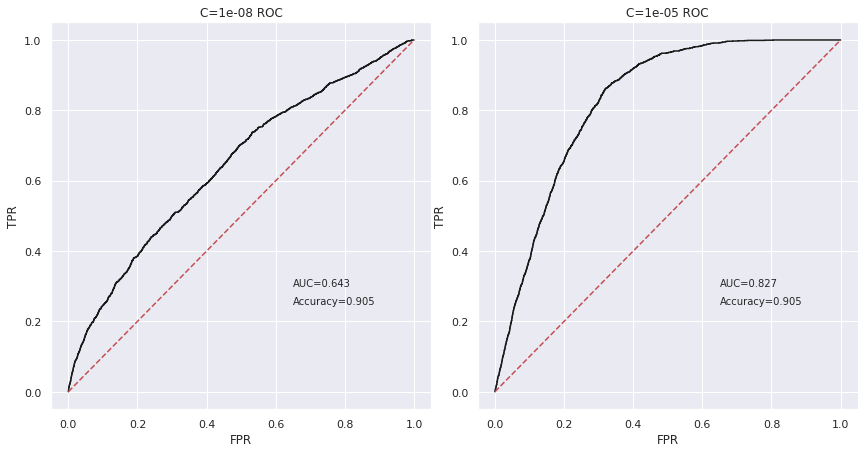

In [19]:
# Train initial, default model
best_log_reg = LogisticRegression(solver='newton-cg', C=1e-08, n_jobs=-1).fit(x_train, y_train)
better_roc_log_reg = LogisticRegression(solver='newton-cg', C=1e-05, n_jobs=-1).fit(x_train, y_train)

fig, (a1, a2) = plt.subplots(1,2) 
fig.set_figheight(6)
fig.set_figwidth(12)
fig.tight_layout()

# Evaluate model
def plot_roc_vals(title, model, plot):
  y_pred = model.predict(x_test)
  yp_proba = model.predict_proba(x_test)
  fpr, tpr, th = roc_curve(y_test, yp_proba[:,1])
  auc = roc_auc_score(y_test, yp_proba[:,1])
  accuracy = accuracy_score(y_test, y_pred)

  # plot
  plot.plot(fpr, tpr, 'k-')
  plot.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
  plot.set_title(title)
  plot.set_xlabel('FPR')
  plot.set_ylabel('TPR')
  plot.text(0.65, 0.3, 'AUC='+"{:.3f}".format(auc))
  plot.text(0.65, 0.25, 'Accuracy='+"{:.3f}".format(accuracy))

plot_roc_vals('C=1e-08 ROC', best_log_reg, a1)
plot_roc_vals('C=1e-05 ROC', better_roc_log_reg, a2)


**Analysis**

Logistic Regression was able to achieve decent accuracy with optimized parameters, but it's ROC curve suggests most misclassifications are False Negatives since it skews up and to the right.

The confusion matrix confirms this:

[[16425    13]
 [ 1722     8]]


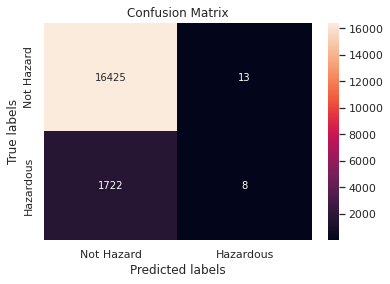

In [31]:
def plot_confusion_matrix(model):
  y_pred = model.predict(x_test)
  confusion = confusion_matrix(y_test, y_pred)
  print(confusion)
  ax = plt.subplot()
  sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(['Not Hazard', 'Hazardous'])
  ax.yaxis.set_ticklabels(['Not Hazard', 'Hazardous'])

plot_confusion_matrix(better_roc_log_reg)

It's worth noting that in when applying this model, it would be best to minimize False Negatives, even at the expense of extra False Positives. We might imagine a NASA alert system which would take observations as inputs, and flag potential hazards to Earth for review. It would be better to review a non-hazard then to miss a threat.

While the Logistic Regression model accuracy is rather high, this is mostly due to the large number of negative samples. Overall, the model is resistant to declare anything "hazardous", only flagging 21 of the 20k test samples.

#### Comparing Logistic Regression to SVM





In [27]:
# Try poly kernel
x_subset, y_subset = x_train[0:5000], y_train[0:5000]
nlsvm = SVC(kernel='poly', C=1, cache_size=4000, probability=True)
nlsvm.fit(x_subset, y_subset)
print(accuracy_score(y_test, nlsvm.predict(x_test)))
# <3sec

0.9047776309995597


In [ ]:
# Try "linear" kernel
nlsvm = SVC(kernel='linear', C=1, cache_size=4000)
nlsvm.fit(x_subset, y_subset)
print(accuracy_score(y_test, nlsvm.predict(x_test)))
# >1hr

In [12]:
# As an alternative to SVC using the linear kernel, the LinearSVC package is 
# optimzied for a larger data set 
from sklearn.svm import LinearSVC
lsvm = LinearSVC(random_state=0, tol=1e-5)
lsvm.fit(x_train, y_train) 
print(accuracy_score(y_test, lsvm.predict(x_test)))

0.8661382650814619


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


**SVM Development**

A few issues were encountered when training SVC models on this data in a Google Colab (Pro) notebook. Most variations took close to an hour to run, and a SearchGrid to find optimal parameters ultimately timed out after 8 hours. In order to experiment more, I reduced the data set to 5000 samples for experimenting with parameters manually which at least allowed for iterations with the "poly" kernel and a decent accuracy result. 

Specific issues encountered:

*   Trying alternative gamma values caused timeouts
*   "rbf" kernel did not finish training on the subset after 2 hours
*   Even the "linear" kernel is relatively slow, hence the attempt to use LinearSVC





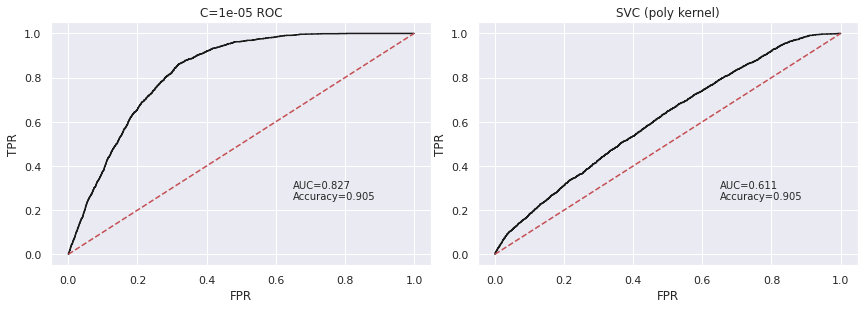

In [34]:
fig, (a1, a2) = plt.subplots(1,2) 
fig.set_figheight(4)
fig.set_figwidth(12)
fig.tight_layout()

plot_roc_vals('C=1e-05 ROC', better_roc_log_reg, a1)
plot_roc_vals('SVC (poly kernel)', nlsvm, a2)


[[16438     0]
 [ 1730     0]]


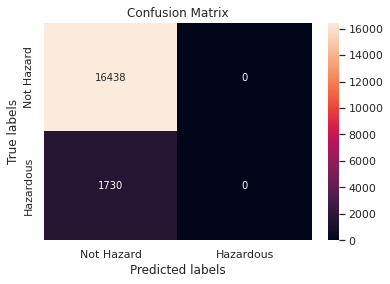

In [32]:
plot_confusion_matrix(nlsvm)

**Comparing SVC to Logistic Regression**

We can see that the best Logistic Regression model's AUC is still higher than the SVC model, and notably that the SVC model is not classifying *any* of the test samples as "hazardous" making it effectively useless. So far Logistic Regression remains the winning model.

### Comparing to Random Forest

Since Logistic Regression already performed relatively well, perhaps a Random Forest classifier built on decision trees will balance training speed with improved model performance.

Below showcases a selection of training iterations with various parameters to optimize accuracy score and AUC.

In [67]:
rf_clf = RandomForestClassifier(max_depth=25, random_state=0, criterion="gini", min_samples_split=8)
rf_clf.fit(x_train, y_train)

# Evaluate accuracy score and ROC
y_pred = rf_clf.predict(x_test)
yp_proba = rf_clf.predict_proba(x_test)
score = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, yp_proba[:,1])

print("Random Forest | Accuracy: {}, AUC: {}".format(score, auc))

# Gini:                           Accuracy: 0.9161712901805372, AUC: 0.9210555409818078
# Entropy:                        Accuracy: 0.9155658300308235, AUC: 0.9197793847190389
# Gini, max depth 30              Accuracy: 0.9200792602377807, AUC: 0.9341896718937581
# Gini, depth 30, min samples 10  Accuracy: 0.9213452223690004, AUC: 0.9357701069072297
# Gini, depth 30, min samples 8   Accuracy: 0.9216754733597534, AUC: 0.9360293750487908
# Gini, depth 25, min samples 8   Accuracy: 0.9222809335094672, AUC: 0.9365058017971892
# Gini, depth 20, min samples 8   Accuracy: 0.9216204315279612, AUC: 0.9347001203330504

Random Forest | Accuracy: 0.9222809335094672, AUC: 0.9365058017971892


Taking the strongest Random Forest model and comparing its ROC curve to the previous best Logistic Regression model, there is some improvement!

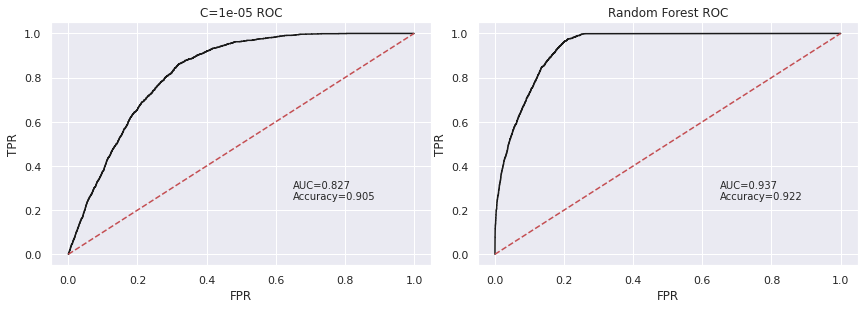

In [68]:
fig, (a1, a2) = plt.subplots(1,2) 
fig.set_figheight(4)
fig.set_figwidth(12)
fig.tight_layout()

plot_roc_vals('C=1e-05 ROC', better_roc_log_reg, a1)
plot_roc_vals('Random Forest ROC', rf_clf, a2)

Now taking a look at the confusion matrix for the Random Forest model, we see significantly more classifications as "hazardous" with most being True Negatives.

[[16172   266]
 [ 1146   584]]


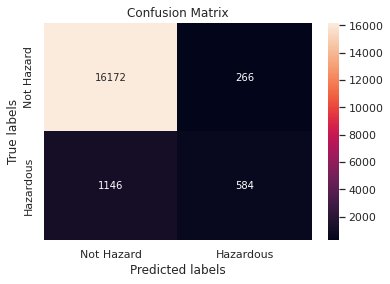

In [69]:
plot_confusion_matrix(rf_clf)

### Conclusion and Discussion

Using 4 features with over 90k observations, it was possible to achieve a 0.937 accuracy with Scikit's implementation of Random Forests. This was improvement on the optimized Logistic Regression model, and it appeared to generalize better to classifying negative samples based on the confusion matrix.

It was disappointing to see that Support Vector Machines did not handle the data well, since they have been applied to anomaly-detection type datasets successfully in other areas. It might be that scikit's particular implementation or the resources available on Google Colab were not geared towards a large dataset with several features and mostly negative samples.

Potential next steps would be trying other ensemble methods (since Random Forests performed well) and trying other SVM implementations on more powerful platforms. There may also be additional potential in feature engineering, such as crossing features, to better prepare the dataset for other methods.